# Model Training and Quantization

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

root_dir = "E:\\Repositories\\personal-projects\\ai-ml-projects\\bmi-classification"
os.chdir(root_dir)

data_path = os.path.join(root_dir, "data", "processed")
log_dir = os.path.join(root_dir, "logs")
model_dir = os.path.join(root_dir, "models")

In [2]:
def plot_loss_and_accuracy(history):
    plt.figure(figsize=(12, 5))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Loss Over Epochs')

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validatioaccuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

### Dataset Preparation

In [3]:
class Dataset:
    def __init__(self, data_path):
        self.data_path = data_path

    def load_data(self):
        data_frames = []
        for file in os.listdir(self.data_path):
            if file.endswith(".csv"):
                data_buffer = pd.read_csv(os.path.join(self.data_path, file))
                data_frames.append(data_buffer)
        
        if not data_frames:
            print("No CSV files found in the specified directory.")
            return None
        
        # Combine all data frames into a single data frame
        combined_data = pd.concat(data_frames, ignore_index=True)
        
        return combined_data
    
    def preprocess_data(self):
        data = self.load_data()
        if data is None:
            return None
        
        X = data.drop(columns=data.columns[-6:]).astype(np.float32)
        y = data[data.columns[-6:]].astype(np.float32)
        
        X_train, X_subset, y_train, y_subset = train_test_split(X, y, test_size=0.2, random_state=seed)
        X_val, X_test, y_val, y_test = train_test_split(X_subset, y_subset, test_size=0.5, random_state=seed)

        return X_train, X_val, X_test, y_train, y_val, y_test

### Model Definition

In [4]:
def BMIModel(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(512)(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

# class BMIModel(keras.Model):
#     def __init__(self, num_classes):
#         super(BMIModel, self).__init__()
#         self.num_layer = 2
#         self.hidden_layer = []
#         for i in range(self.num_layer):
#             self.hidden_layer.append(layers.Dense(512, activation='relu'))
#         self.batch_norm = layers.BatchNormalization()
#         self.dropout = layers.Dropout(0.1)
#         self.output_layer = layers.Dense(num_classes, activation='softmax')

#     def call(self, inputs):
#         x = inputs
#         for i in range(self.num_layer):
#             x = self.hidden_layer[i](x)
#         x = self.batch_norm(x)
#         x = self.dropout(x)
#         x = self.output_layer(x)
#         return x


### Base Model Training

In [5]:
# Preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = Dataset(data_path).preprocess_data()

def lrdecay(epoch):
    lr = 0.01
    if epoch > 40:
        lr *= 0.5 ** ((epoch - 40) // 5)
    elif epoch > 20:
        lr *= 0.1
    return lr

# Create the learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lrdecay, verbose=1)

# Instantiate the model with a different variable name
bmi_model = BMIModel(X_train.shape[1], y_train.shape[1])

# Build the model
bmi_model.build(input_shape=(None, X_train.shape[1]))

# Compile the model
bmi_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


bmi_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 512)               2048      
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                             

In [6]:
history = bmi_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), shuffle=False, callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
23/23 [==============================] - 1s 17ms/step - loss: 1.0334 - accuracy: 0.6375 - val_loss: 1.3972 - val_accuracy: 0.4444 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5962 - accuracy: 0.7653 - val_loss: 2.4145 - val_accuracy: 0.4111 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5240 - accuracy: 0.7792 - val_loss: 2.2974 - val_accuracy: 0.4333 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5021 - accuracy: 0.7903 - val_loss: 2.0108 - val_accuracy: 0.4778 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - l

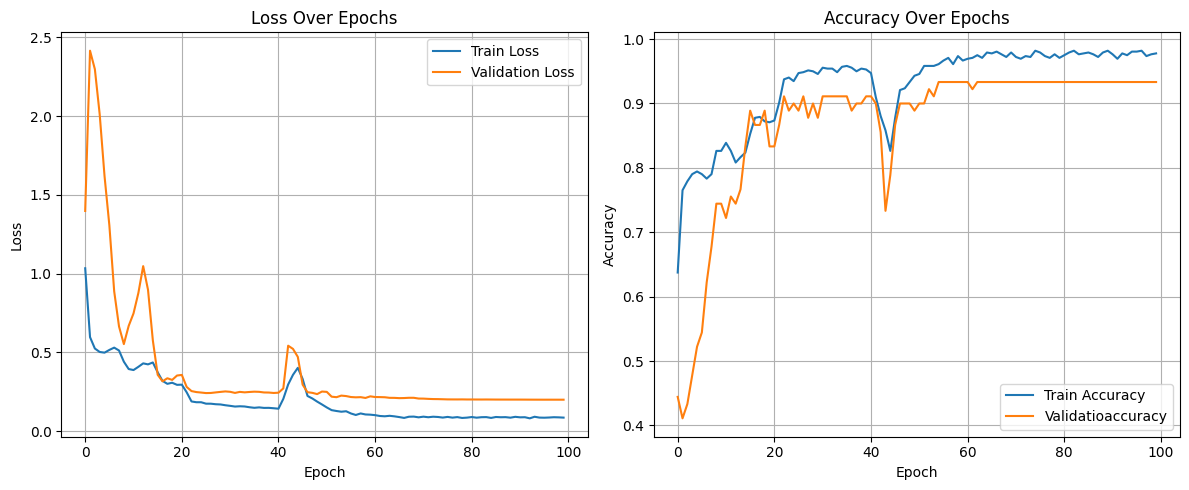

In [7]:
plot_loss_and_accuracy(history)

In [8]:
val_loss, val_accuracy = bmi_model.evaluate(X_test, y_test, verbose=2)
print(f'Validation accuracy: {val_accuracy}')

3/3 - 0s - loss: 0.1907 - accuracy: 0.9444 - 25ms/epoch - 8ms/step
Validation accuracy: 0.9444444179534912


### Float Quantization

In [9]:
converter_1 = tf.lite.TFLiteConverter.from_keras_model(bmi_model)
converter_1.optimizations = [tf.lite.Optimize.DEFAULT]
float_quant_model = converter_1.convert()

with open(file = os.path.join(model_dir, 'BMIModel-Float.tflite'), mode = 'wb') as f:
    f.write(float_quant_model)

INFO:tensorflow:Assets written to: C:\Users\muham\AppData\Local\Temp\tmp1gipxpha\assets


### Quantization Aware Training Model

In [12]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(bmi_model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 quantize_layer_1 (QuantizeL  (None, 3)                3         
 ayer)                                                           
                                                                 
 quant_dense (QuantizeWrappe  (None, 512)              2049      
 rV2)                                                            
                                                                 
 quant_activation (QuantizeW  (None, 512)              3         
 rapperV2)                                                       
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 512)              262659    
 perV2)                                                      

In [13]:
q_aware_model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/5
23/23 [==============================] - 1s 16ms/step - loss: 0.1066 - accuracy: 0.9653 - val_loss: 0.2199 - val_accuracy: 0.9222
Epoch 2/5
23/23 [==============================] - 0s 8ms/step - loss: 0.1074 - accuracy: 0.9653 - val_loss: 0.2129 - val_accuracy: 0.9333
Epoch 3/5
23/23 [==============================] - 0s 8ms/step - loss: 0.0962 - accuracy: 0.9764 - val_loss: 0.2217 - val_accuracy: 0.9222
Epoch 4/5
23/23 [==============================] - 0s 8ms/step - loss: 0.0874 - accuracy: 0.9778 - val_loss: 0.2040 - val_accuracy: 0.9444
Epoch 5/5
23/23 [==============================] - 0s 8ms/step - loss: 0.0834 - accuracy: 0.9764 - val_loss: 0.2075 - val_accuracy: 0.9333


In [14]:
converter_2 = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter_2.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter_2.convert()

with open(file = os.path.join(model_dir, 'BMIModel-Quantized.tflite'), mode = 'wb') as f:
    f.write(quantized_tflite_model)

INFO:tensorflow:Assets written to: C:\Users\muham\AppData\Local\Temp\tmp2mnyadkj\assets


INFO:tensorflow:Assets written to: C:\Users\muham\AppData\Local\Temp\tmp2mnyadkj\assets
c:\Users\muham\miniconda3\envs\mlenv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


## Model Evaluation

In [18]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [29]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Index_0  90 non-null     float32
 1   Index_1  90 non-null     float32
 2   Index_2  90 non-null     float32
 3   Index_3  90 non-null     float32
 4   Index_4  90 non-null     float32
 5   Index_5  90 non-null     float32
dtypes: float32(6)
memory usage: 2.2 KB


In [30]:
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i in range(len(X_test)):
        input_data = np.array(X_test.iloc[i].values.reshape(1, -1), dtype=np.float32)
        interpreter.set_tensor(input_index, input_data)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest probability.
        output = interpreter.get_tensor(output_index)
        digit = np.argmax(output, axis=1)[0]
        prediction_digits.append(digit)

    # Convert y_test to NumPy array and ensure the lengths of y_test and prediction_digits are consistent
    y_test_array = y_test.to_numpy()
    y_test_labels = np.argmax(y_test_array, axis=1)  # Convert one-hot encoded y_test to class labels

    print(f"Length of y_test: {len(y_test_labels)}")
    print(f"Length of prediction_digits: {len(prediction_digits)}")

    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    confussion_matrix = confusion_matrix(y_test_labels, prediction_digits)
    classification_reports = classification_report(y_test_labels, prediction_digits)
    accuracy = accuracy_score(y_test_labels, prediction_digits)
    precision = precision_score(y_test_labels, prediction_digits, average='weighted')
    recall = recall_score(y_test_labels, prediction_digits, average='weighted')
    f1 = f1_score(y_test_labels, prediction_digits, average='weighted')

    print('Classification Report:\n', classification_reports)
    print('Accuracy:', accuracy)
    print('Precision Score:', precision)
    print('Recall Score:', recall)
    print('F1 Score:', f1)
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(confussion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [31]:
def evaluate_base_model(model):
    yhat = model.predict(X_test)
    yhat = np.argmax(yhat, axis=1)

    confussion_matrix = confusion_matrix(np.argmax(y_test, axis=1), yhat)
    classification_reports = classification_report(np.argmax(y_test, axis=1), yhat)
    accuracy = accuracy_score(np.argmax(y_test, axis=1), yhat)
    precision = precision_score(np.argmax(y_test, axis=1), yhat, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), yhat, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), yhat, average='weighted')

    print('Classification Report:\n', classification_reports)
    print('Accuracy:', accuracy)
    print('Precission Score:', precision)
    print('Recall Score:', recall)
    print('F1 Score:', f1)
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(confussion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

### Float Quantization

Length of y_test: 90
Length of prediction_digits: 90
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.67      0.80         3
           2       0.93      0.93      0.93        15
           3       0.94      1.00      0.97        15
           4       0.88      0.95      0.91        22
           5       1.00      0.94      0.97        33

    accuracy                           0.94        90
   macro avg       0.96      0.92      0.93        90
weighted avg       0.95      0.94      0.94        90

Accuracy: 0.9444444444444444
Precision Score: 0.9479166666666666
Recall Score: 0.9444444444444444
F1 Score: 0.9441315061555244


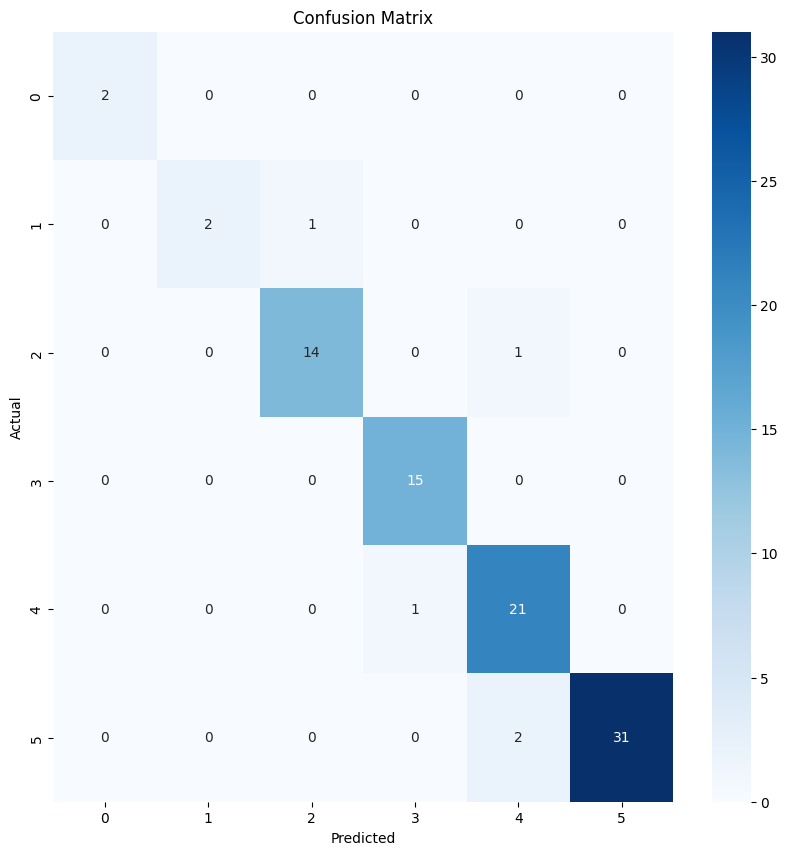

In [32]:
interpreter_1 = tf.lite.Interpreter(model_content = float_quant_model)
interpreter_1.allocate_tensors()

evaluate_model(interpreter_1)

### Quantization Aware Training 

Length of y_test: 90
Length of prediction_digits: 90
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.67      0.80         3
           2       0.93      0.93      0.93        15
           3       1.00      1.00      1.00        15
           4       0.88      1.00      0.94        22
           5       1.00      0.94      0.97        33

    accuracy                           0.96        90
   macro avg       0.97      0.92      0.94        90
weighted avg       0.96      0.96      0.96        90

Accuracy: 0.9555555555555556
Precision Score: 0.9595555555555555
Recall Score: 0.9555555555555556
F1 Score: 0.9551610520094562


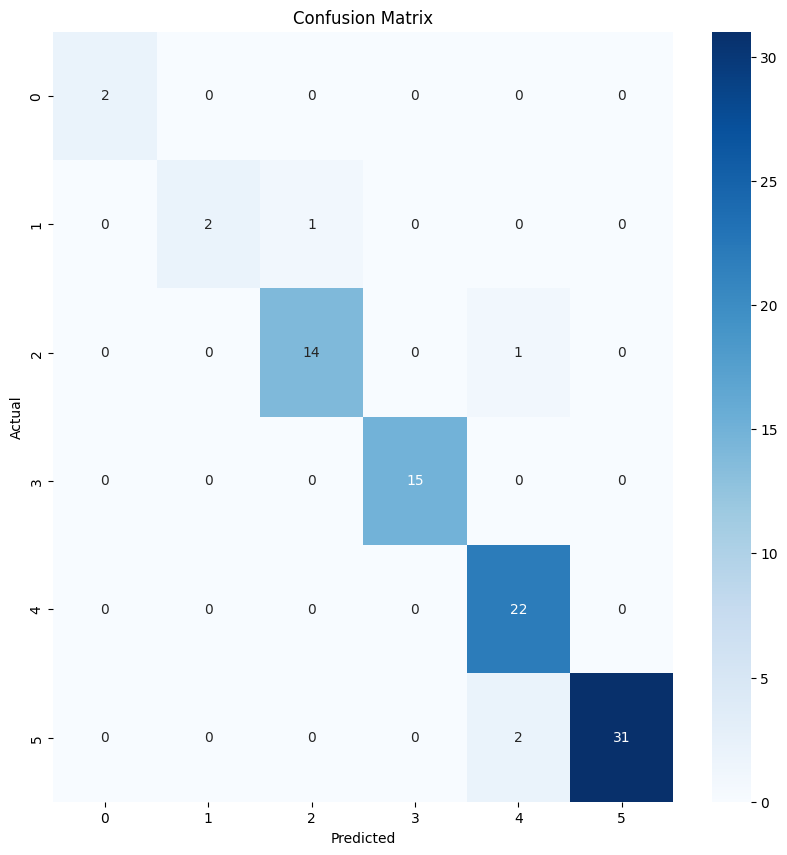

In [33]:
interpreter_2 = tf.lite.Interpreter(model_content = quantized_tflite_model)
interpreter_2.allocate_tensors()

evaluate_model(interpreter_2)

### Base Model

3/3 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.67      0.80         3
           2       0.93      0.93      0.93        15
           3       0.94      1.00      0.97        15
           4       0.88      0.95      0.91        22
           5       1.00      0.94      0.97        33

    accuracy                           0.94        90
   macro avg       0.96      0.92      0.93        90
weighted avg       0.95      0.94      0.94        90

Accuracy: 0.9444444444444444
Precission Score: 0.9479166666666666
Recall Score: 0.9444444444444444
F1 Score: 0.9441315061555244


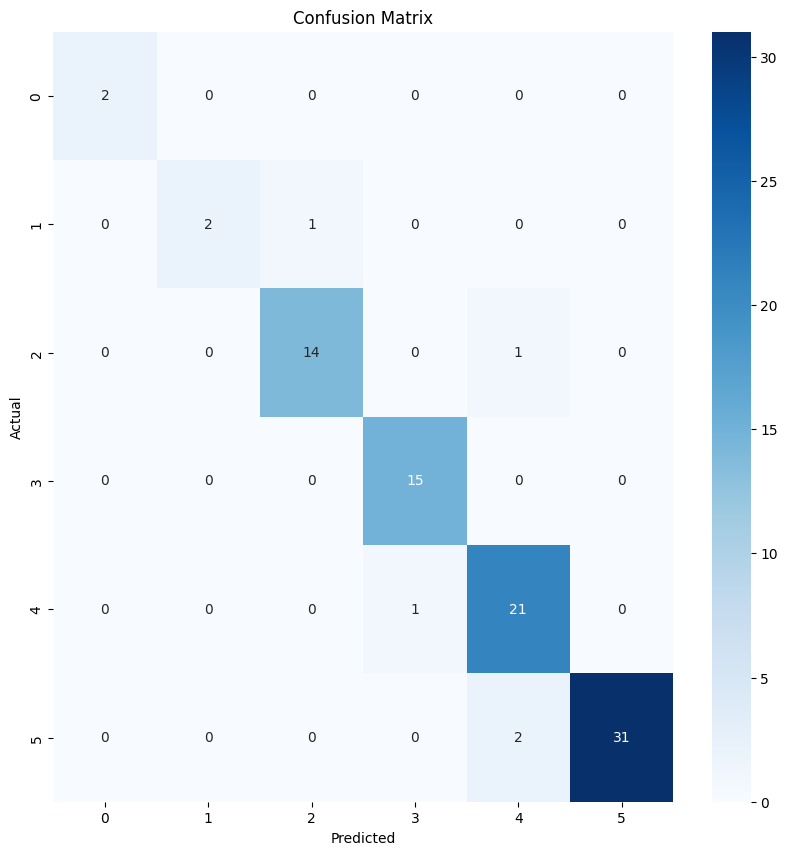

In [34]:
evaluate_base_model(bmi_model)

In [37]:
bmi_model.save(os.path.join(model_dir, 'BMIModel.h5'))
bmi_model.save(os.path.join(model_dir, 'BMIModel_SavedModel-tf'), save_format='tf')

INFO:tensorflow:Assets written to: E:\Repositories\personal-projects\ai-ml-projects\bmi-classification\models\BMIModel_SavedModel-tf\assets


INFO:tensorflow:Assets written to: E:\Repositories\personal-projects\ai-ml-projects\bmi-classification\models\BMIModel_SavedModel-tf\assets


In [38]:
bmi_model.save(os.path.join(model_dir, 'BMIModel_SavedModel-keras'), save_format='keras')

INFO:tensorflow:Assets written to: E:\Repositories\personal-projects\ai-ml-projects\bmi-classification\models\BMIModel_SavedModel-keras\assets


INFO:tensorflow:Assets written to: E:\Repositories\personal-projects\ai-ml-projects\bmi-classification\models\BMIModel_SavedModel-keras\assets
